In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn import Module

from context import *
from LocalLearning import ModelFactory, HiddenLayerModel, KHModel, SHLP, FKHL3
from LocalLearning.Data import BaselineAccurateTestData, LpUnitCIFAR10, DeviceDataLoader, GaussianData
from LocalLearning.Attacks import AdversarialAttack, WhiteGaussianPerturbation, FGSM, PGD, AttackTest
from LocalLearning.Experiments import PerturbationExperiment, RandomPerturbationExperiment, FGSMExperiment, PGDExperiment
from LocalLearning.Statistics import cov_spectrum
from scipy import stats

from pathlib import Path
from collections import OrderedDict
import pickle as pkl

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use(['seaborn-paper', "./ICLRFullTextwidthFigureStyle.mplstyle"])

In [2]:
# path variables
# model directory
directory = Path("../data/repro/models")
figure_directory = Path("../data/repro/figures")

# model filenames
khmodel_name = Path("khmodel_cifar10_pruned.pty")
shlp_init_name = Path("shlp_init.pty")
shlp_name = Path("shlp_cifar10.pty")
shlp_l2_name = Path("shlp_l2.pty")
shlp_jreg_name = Path("shlp_jreg.pty")
shlp_specreg_name = Path("shlp_specreg.pty")

fn_list = [khmodel_name, shlp_name, shlp_l2_name, shlp_jreg_name, shlp_specreg_name]
#fn_list = [shlp_name, khmodel_name]

# hyper parameters
BATCH_SIZE = 1000

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
cifar10Test = LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=FKHL3.pSet["p"],
)

Files already downloaded and verified


In [5]:
# load model to test
mFactory = ModelFactory()
state_dict = torch.load(directory / shlp_name)
model = mFactory.build_from_state(state_dict) 

In [6]:
LOAD = True
if not LOAD:
    # randomly sample from dataset
    i_sample = int(torch.rand(1)*len(cifar10Test.data))
    x_i = torch.Tensor(cifar10Test.data[i_sample])
    x_i = x_i.to(device)
    
    # sample two directions spanning the plane
    u = torch.randn(x_i.size())
    v = torch.randn(x_i.size())
    # normalize
    u /= torch.norm(u)
    v /= torch.norm(v)
    # and send to cuda device
    u = u.to(device)
    v = v.to(device)
    
    random_sample = {
        'i_sample': i_sample,
        'x_i': x_i,
        'u': u,
        'v': v,
    }
    #torch.save(random_sample, directory / Path('random_plane.pty'))
else:
    random_sample = torch.load(directory / Path('random_plane.pty'))
    i_sample = random_sample['i_sample']
    x_i = random_sample['x_i']
    u = random_sample['u']
    v = random_sample['v']

In [7]:
r_x = 20.0
r_y = 20.0
num = 100

eps = torch.linspace(-r_x, +r_x, steps=num, device=device)
xis = torch.linspace(-r_y, +r_y, steps=num, device=device)

In [33]:
def JFrob(h_batch: torch.Tensor, x_batch: torch.Tensor) -> torch.Tensor:
    '''
    Calculates the Frobenius Norm of the Jacobian of the latent hidden representation h
    with respect to the inputs x
    '''
    x_batch_shape = x_batch.shape
    batch_size, hsize = h_batch.shape
    J_F = torch.zeros((batch_size,), device=u.device)
    for mu in range(hsize):
        proj = torch.zeros(batch_size, hsize, device=u.device)
        proj[:,mu] = 1
        Jproj = torch.autograd.grad(
            h_batch, 
            x_batch, 
            proj, 
            create_graph=True)[0]
        Jproj = Jproj.reshape(batch_size, -1).detach()
        J_F += torch.norm(Jproj, dim=-1)**2
    return torch.sqrt(J_F)


def PlotDecisionBoundaries(
    directory: Path, fn_list: list, name_list: list, # directory and list of file names of the models to load
    x0: torch.Tensor, # starting image from which to perturb input
    u: torch.Tensor, v: torch.Tensor, # unit vector bundle, spanning the perturbance plane
    eps: torch.Tensor, xis: torch.Tensor, # perturbation magnitudes in u and v directions
    no_contours: int = 20,
):
    fig = plt.figure()
    fig.set_figheight(2.0)
    #fig.set_size_inches(5.50107, 3)
    #fig.tight_layout()
    
    width_ratios = []
    for _ in range(len(fn_list)):
        width_ratios.append(1.0)
    width_ratios.append(0.1)
    
    gs = mpl.gridspec.GridSpec(2, len(fn_list) + 1, width_ratios=width_ratios, height_ratios=[1, 1])
    
    mFactory = ModelFactory()
    softmax = torch.nn.Softmax(dim=1)
    
    # color list from color brewer
    clr_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

    # create the new color maps
    cmap_db = mpl.colors.LinearSegmentedColormap.from_list(
        'ClassifyMap', clr_list, 10)
    cmap_jc = mpl.colormaps['magma']

    # define the bins and normalize
    bounds = np.linspace(0, 10, 11)
    norm = mpl.colors.BoundaryNorm(bounds, cmap_db.N)
    
    extent = float(eps.min()), float(eps.max()), float(xis.min()), float(xis.max())  
    
    first_ax_db = None
    first_ax_jc = None
    for i, fn in enumerate(fn_list):
        # load and configure the model to test
        state_dict = torch.load(directory / fn)
        model = mFactory.build_from_state(state_dict) 
        model.to(u.device)
        model.eval()
        
        # construct the plane of pertubation based on the basis vectors
        EPS, XIS = torch.meshgrid(eps, xis, indexing='ij')
        plane = x_i.T[..., None, None] + u.T[..., None, None]*EPS + v.T[..., None, None]*XIS
        plane = plane.T
        plane_shape = plane.shape
        
        # batchify to process by the model
        batch_size = (-1, ) + tuple(plane.size()[2:])
        plane_batch = plane.reshape(batch_size)
        plane_batch = plane_batch.requires_grad_(True)
        #process by the model
        preds, hidden = model(plane_batch)
        latent_activation = torch.pow(torch.nn.functional.relu(hidden), model.pSet['n'])
        
        JF_np = JFrob(latent_activation, plane_batch).reshape(plane_shape[:-3]).cpu().numpy()
        # plot the jacobian activation landscape
        jf_min = float(torch.Tensor(JF_np).min())
        jf_max = float(torch.Tensor(JF_np).max())
        norm_jc = mpl.colors.Normalize(vmin=jf_min, vmax=jf_max)
        ax_jc = fig.add_subplot(gs[0, i])
        if i == 0:
            first_ax_jc = ax_jc
        ax_jc.imshow(JF_np, cmap=cmap_jc, norm=norm_jc, extent=extent, origin='lower')
        ax_jc.set_title(name_list[i])
        ax_jc.set_xticks([])
        ax_jc.set_yticks([])
        ax_jc.get_xaxis().set_visible(False)
        ax_jc.get_yaxis().set_visible(False)
        ax_jc.spines[['left', 'bottom']].set_visible(False)
        #ax_jc.set_xlabel(r"$\xi$")
        #ax_jc.set_ylabel(r"$\zeta$")
        # add colorbar
        divider = make_axes_locatable(ax_jc)
        cax_jc = divider.append_axes("right", size="5%", pad=0.01)
        sm_jc = plt.cm.ScalarMappable(cmap=cmap_jc, norm=norm_jc)
        cbar = fig.colorbar(sm_jc, cax=cax_jc)
        cbar.ax.tick_params(
            axis='both',
            length=1.,
            width=1.,
            labelsize=6,
        )
        
        # calculate the s_max height profile
        s_max = softmax(preds)
        s_max, _ = torch.max(s_max, dim=1)
        
        # calculate class predictions
        class_preds = torch.argmax(preds, dim=1)
        
        # reshaping tensors into the image coordinates
        s_max = s_max.reshape(tuple(plane_shape[:-3]))
        class_preds = class_preds.reshape(tuple(plane_shape[:-3]))
        
        # numpyfy tensors
        class_preds_np = class_preds.detach().cpu().numpy()
        s_max_np = s_max.detach().cpu().numpy()
        EPS_np = EPS.detach().cpu().numpy()
        XIS_np = XIS.detach().cpu().numpy()
        
        # plot decision boundaries in current axes
        ax_db = fig.add_subplot(gs[1, i])
        if i == 0:
            first_ax_db = ax_db
        ax_db.contour(EPS_np, XIS_np, s_max_np.T, 20, colors='k', linewidths=.1)
        ax_db.imshow(class_preds_np, cmap=cmap_db, norm=norm, alpha=s_max_np, extent=extent, origin='lower')
        ax_db.set_xticks([])
        ax_db.set_yticks([])
        ax_db.get_xaxis().set_visible(False)
        ax_db.get_yaxis().set_visible(False)
        ax_db.spines[['left', 'bottom']].set_visible(False)
        #ax_db.set_xlabel(r"$\xi$")
        #ax_db.set_ylabel(r"$\zeta$")
    
    sm_db = plt.cm.ScalarMappable(cmap=cmap_db, norm=norm)
    sm_db.set_array([])
    cax_db = fig.add_subplot(gs[1, len(fn_list)])
    cax_db.get_xaxis().set_visible(False)
    cax_db.yaxis.tick_right()
    cbar_db = fig.colorbar(sm_db, cax=cax_db) 
    cax_db.set_yticks(
        ticks=np.arange(0, 9 + 1) + 0.5, 
        labels=[str(no) for no in np.arange(0, 9 + 1)],
    )
    cbar_db.ax.tick_params(
        axis='both',
        length=1.,
        width=1.,
        labelsize=6,
    )
    
    # add the figure descriptive text
    #fig.text(
    #    0.06, 0.7, r"$\|J\|_{F}$", 
    #    fontsize=10, rotation='horizontal',
    #)   
    #first_ax_jc.text(-0.1, 1.1, "a)", fontsize=10)
    #first_ax_db.text(-0.1, 1.1, "b)", fontsize=10)
    
    return fig

In [20]:
def make_orthonormal(u: torch.Tensor, v: torch.Tensor) -> tuple:
    orig_u_shape = u.shape
    orig_v_shape = v.shape
    # flatten
    u_d = u.reshape(-1)
    v_d = v.reshape(-1)
    u_hat = u_d / torch.norm(u_d)
    v_hat = v_d - torch.dot(v_d, u_hat)*u_hat
    v_hat /= torch.norm(v_hat)
    return (u_hat.reshape(orig_u_shape).clone(), v_hat.reshape(orig_v_shape).clone())

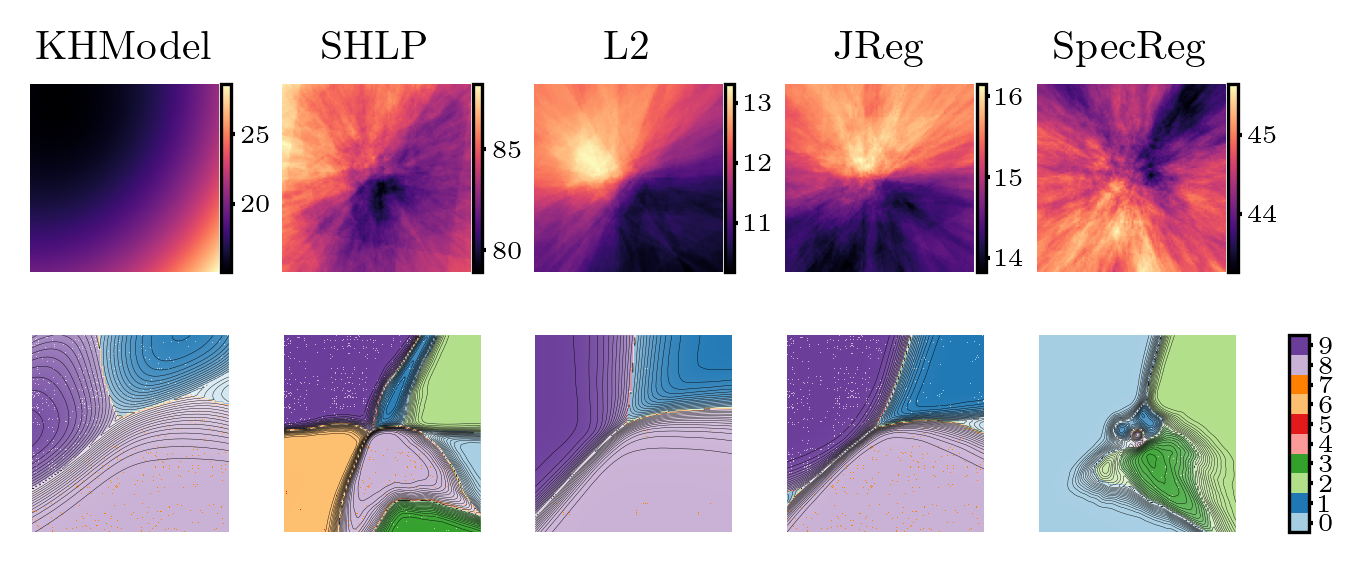

In [34]:
u_hat, v_hat = make_orthonormal(u, v)

fig = PlotDecisionBoundaries(
    directory, fn_list, ['KHModel', 'SHLP', 'L2', 'JReg', 'SpecReg'],
    x_i, 
    u_hat, v_hat,
    eps, xis,
    no_contours=10,
)
fig.savefig(figure_directory / Path("Figure4-JacobianLandscapesAndDecisionBoundaries.eps"))